In [66]:
# from data_loader import *
from model import *
# from loss import *

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
from torchvision import transforms
import os
from torch.autograd import Function
from torch import nn
import matplotlib.pyplot as plt

In [22]:
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select2_parts_16/"

classes = ['background', 'road']
colormap = [[0 , 0, 0], [255, 255, 255]]

INPUT_SIZE, OUTPUT_SIZE = 256, 256

In [6]:
class RoadDataset(Dataset):
    def __init__(self, root_path, input_size, output_size, train = True):
        super(RoadDataset, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.root_path = root_path
        
        # absolute paths
        self.data_list, self.label_list = self.read_images(train = train)
        self.len = len(self.data_list)
        
        # text out
        print('Train set: {}\nCount: {} pairs'.format(train, self.len))
    
    # get paths (images with corresponding labels)
    def read_images(self, train):
        type_str = "train" if train else "val"
        data = [self.root_path + "/" + type_str + "/" + file_name for file_name in list(os.walk(self.root_path+"/" + type_str + "/"))[0][2]]
        file_names_order = [path.split("/")[-1][:-1] for path in data]
        labels = [self.root_path + "/" + type_str + "_labels/" + file_name for file_name in file_names_order]
        return data, labels
    
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img, label = self.change_to_tensor(img, label)
        return img, label
    
    def __len__(self):
        return self.len
    
    # 0-255 to 0-1 in tensors
    def change_to_tensor(self, img, label):
        img = cv2.imread(img)
        label = cv2.imread(label)
        # for every class
        for i, cm in enumerate(colormap):
            label[(label[:, :, 0] == cm[0]) & (label[:, :, 1] == cm[1]) & (label[:, :, 2] == cm[2])] = i * 255
        label = label[:, :, 0] 
        transform_data = transforms.Compose([transforms.Resize([self.input_size, self.input_size], 0), transforms.ToTensor(),])
        transform_label = transforms.Compose([transforms.Resize([self.output_size, self.output_size], 0), transforms.ToTensor(),])
        img_tensor, label_tensor = transform_data(Image.fromarray(img)), transform_label(Image.fromarray(label))
        
        return img_tensor, label_tensor

In [7]:
train_dataset = RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, True)

Train set: True
Count: 7056 pairs


In [8]:
val_dataset = RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, False)

Train set: False
Count: 224 pairs


In [15]:
class dice_bce_loss(nn.Module):
    def __init__(self, batch = True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()
        
    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss
        
    def __call__(self, y_true, y_pred):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a + b

In [23]:
class DiceCoeff(Function):

    # tensors are feeded in forward()
    def forward(self, input, target):
        self.save_for_backward(input, target) # tensor 转化为变量保存到后续操作
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):
        input, target = self.saved_variables
        grad_input = grad_target = None
        # if 'input' needs grad
        print(self.needs_input_grad)
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) / (self.union * self.union)
        # if 'target' needs grad
        if self.needs_input_grad[1]:
            grad_target = None
        return grad_input, grad_target

class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
    
    def __call__(self, input, target):
        s = torch.FloatTensor(1).cuda().zero_() if input.is_cuda else torch.FloatTensor(1).zero_()
        for i, c in enumerate(zip(input, target)):
            s = s + DiceCoeff().forward(c[0], c[1])
        return s / (i + 1)

In [24]:
dice_bce = dice_bce_loss()
dice = dice_loss()

In [25]:
net = LinkNet34()

In [46]:
imgs, lbls = next(iter(train_dataset))
lbls = lbls.unsqueeze(dim = 0)

In [47]:
np.transpose(imgs, (1, 2, 0)).shape

torch.Size([256, 256, 3])

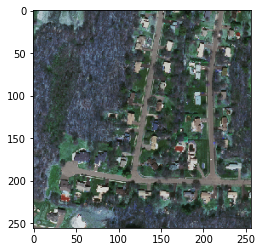

In [48]:
plt.imshow(np.transpose(imgs, (1, 2, 0)))

In [49]:
pred = net(imgs.unsqueeze(dim = 0))

In [50]:
lbls.shape, pred.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

In [53]:
dice_bce(lbls, pred)

tensor(1.6153, grad_fn=<AddBackward0>)

In [54]:
dice(pred, lbls)

tensor([0.1305], grad_fn=<DivBackward0>)

In [71]:
list1 = []
list2 = []
for imgs, lbls in zip(val_loader):
    print(imgs.shape, lbls.shape, net(imgs.shape))
    break

ValueError: not enough values to unpack (expected 2, got 1)

In [62]:
val_dataset[0][0].shape

torch.Size([3, 256, 256])

In [86]:
val_loader = DataLoader(val_dataset, 4, shuffle = False)

In [96]:
for i, batch in enumerate(zip(val_loader)):
    print(i)
    print(len(batch[0]))
    break

0
2
